# Biosensing Analysis

### This notebook walks through the biosensing analysis: segmenting the image, calculating intensity and plotting against refractive index

In [1]:
import os
import json
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Extract NaCl percentage and images

In [2]:
data_dir = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_"

def extract_params(filename, equals=None):
    """
    Extracts the NaCl percentage from the filename.
    
    Args:
        filename (str): The name of the image file.
        
    Returns:
        dict: A dictionary with the file path and NaCl percentage.
    """
    if filename.endswith(".jpg"):
        name = filename.replace(",", ".")
        parts = name.split("-")
        prefix = "-".join(parts[:3])
        nacl_percentage = float(parts[3].strip("_"))
        chip_part = parts[4]
        if equals is not None:
            batch_name = "-".join(["-".join(parts[:3]), chip_part])
            if f"{equals}.jpg" != batch_name:
                return None
        return {
            "nacl_percentage": nacl_percentage,
            "group": "-".join([prefix, chip_part])
        }
            

def data_preprocessing(path, equals=None):
    data = {}
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            params = extract_params(filename, equals)
            if params is None:
                continue
            if params["group"] not in data.keys():
                data[params["group"]] = []
            data[params["group"]].append({
                "file_path": os.path.join(path, filename),
                "nacl_percentage": params["nacl_percentage"]
            })
    for group in data.keys():
        data[group] = sorted(data[group], key=lambda x: x["nacl_percentage"])
    return data
    
data = data_preprocessing(data_dir, equals="290-4-0.75x-3")
print(json.dumps(data, indent=4))

{
    "290-4-0.75x-3.jpg": [
        {
            "file_path": "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\\290-4-0,75x-0_-3.jpg",
            "nacl_percentage": 0.0
        },
        {
            "file_path": "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\\290-4-0,75x-1,3_-3.jpg",
            "nacl_percentage": 1.3
        },
        {
            "file_path": "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\\290-4-0,75x-2,6_-3.jpg",
            "nacl_percentage": 2.6
        },
        {
            "file_path": "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\\290-4-0,75x-3,9_-3.jpg",
            "nacl_percentage": 3.9
        },
        {
            "file_path": "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\\290-4-0,75x-5,2_-3.jpg",
            "nacl_percentage": 5.2
        },
        {
        

### Initialize SAM2

In [3]:
# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

model_cfg = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/sam2/sam2/configs/sam2.1/sam2.1_hiera_b+.yaml"
checkpoint_base = "C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/sam2/checkpoints/sam2.1_hiera_base_plus.pt"
sam2_base = build_sam2(model_cfg, checkpoint_base, device="cuda")
generator = SAM2AutomaticMaskGenerator(
    sam2_base,
    points_per_side=96
)


### Helper Functions

In [4]:
# Mask visualization for AMG masks
def show_anns(anns, ax=None, color_mask=np.array([0.0, 1.0, 0.0, 0.5])):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) 
    if ax is None:
        ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        img[m] = color_mask 
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

# Function to calculate circularity of a contour
def compute_circularity(mask):
    mask_uint8 = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0  # No valid contour found

    contour = max(contours, key=cv2.contourArea)  # Get the largest contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:  # Avoid division by zero
        return 0

    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

### Perform Segmentation

Image 0 - 290-4-0,75x-0_-3.jpg has all masks
Image 1 - 290-4-0,75x-1,3_-3.jpg has all masks
Image 2 - 290-4-0,75x-2,6_-3.jpg has all masks
Image 3 - 290-4-0,75x-3,9_-3.jpg has all masks
Image 4 - 290-4-0,75x-5,2_-3.jpg has all masks
Image 5 - 290-4-0,75x-6,5_-3.jpg has all masks
Image 6 - 290-4-0,75x-10,4_-3.jpg has all masks
Image 7 - 290-4-0,75x-14,7_-3.jpg has all masks
Image 8 - 290-4-0,75x-19_-3.jpg has all masks


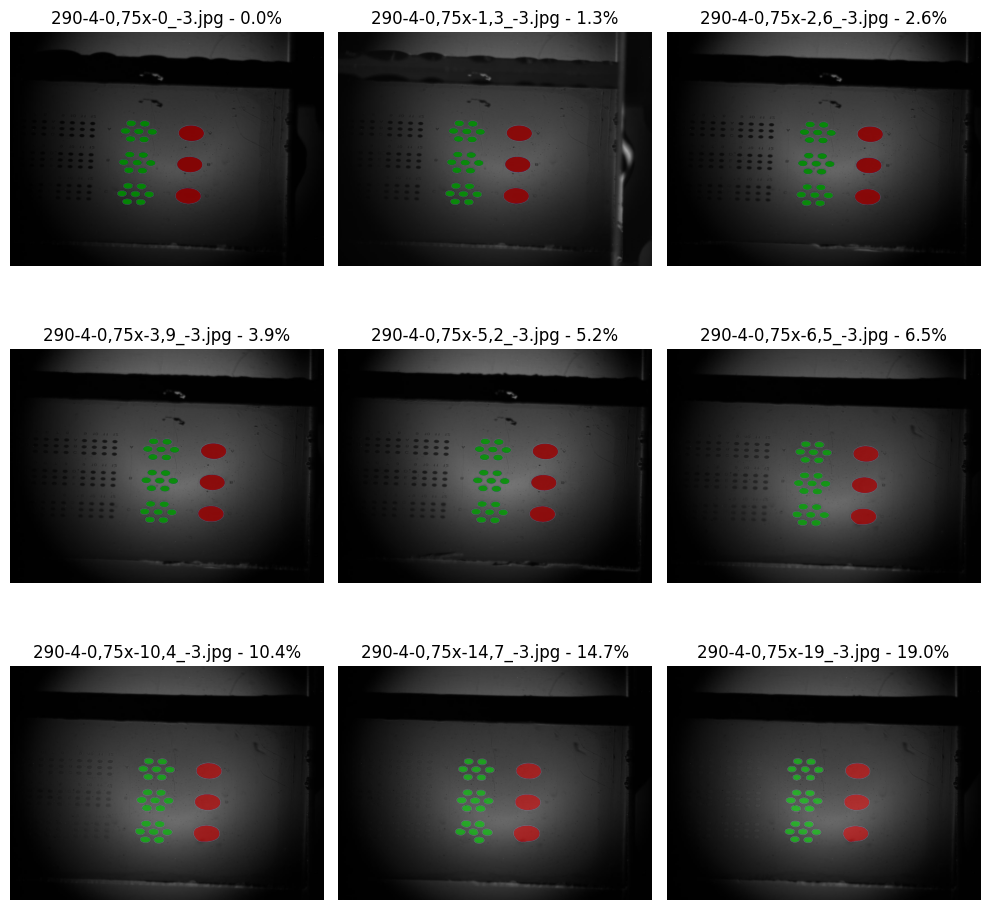

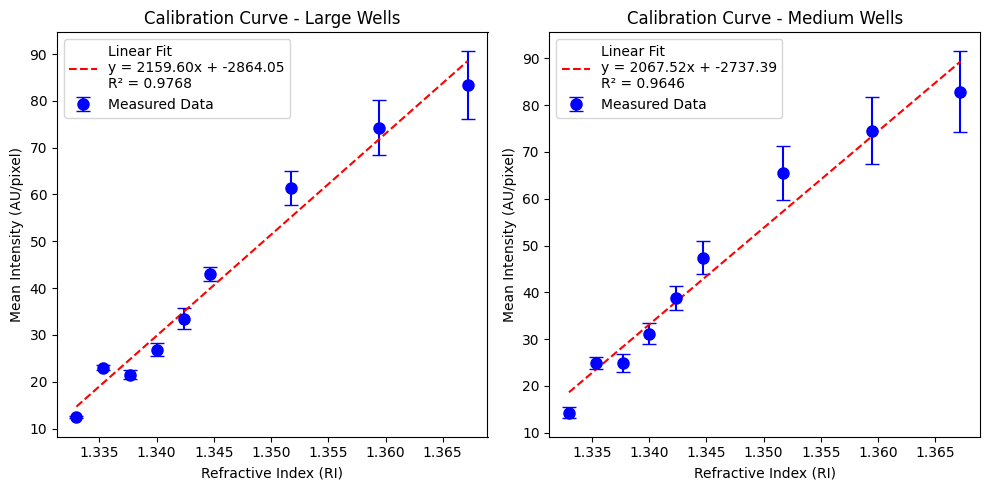


===== Calibration Data =====
 NaCl_percentage  mean_intensity_large  std_intensity_large  mean_intensity_medium  std_intensity_medium  mean_intensity_small  std_intensity_small  mean_intensity_all  std_intensity_all  num_wells                                                                                                 image_path              image_name      RI
             0.0             12.479941             0.294931              14.290774              1.242790             10.654606             2.470220           12.336160           2.572493         53    C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\290-4-0,75x-0_-3.jpg    290-4-0,75x-0_-3.jpg 1.33300
             1.3             23.042132             0.515625              24.879150              1.218596             18.888191             3.272346           21.612669           3.790857         56  C:/Users/Micha/Desktop/BachelorProject/AI-Powered-Biosensing/data/Chip2-NaCl 0-19_\290-4-0,75x-1,

In [9]:
def segment_image(image_path, generator):
    image = np.array(Image.open(image_path).convert("RGB"))
    masks = generator.generate(image)
    
    height, width = image.shape[:2]
    image_area = height * width

    # Filter masks based on area and circularity
    masks = [mask for mask in masks if 0.00015 < mask['area'] / image_area < 0.005]
    masks = [mask for mask in masks if compute_circularity(mask['segmentation']) >= 0.75]
    
    # Group masks by well size
    masks_large = [mask for mask in masks if mask['area'] / image_area > 0.003]
    masks_medium = [mask for mask in masks if 0.0005 < mask['area'] / image_area < 0.001]
    masks_small = [mask for mask in masks if mask['area'] / image_area <= 0.0005]

    
    return masks, masks_large, masks_medium, masks_small


def calculate_intensity(gray_image, masks):
    circle_masks = []
    for mask in masks:
        m = mask["segmentation"].astype(np.uint8)
        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        M = cv2.moments(m)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0  # fallback if mask is empty
        (_, _), radius = cv2.minEnclosingCircle(contours[0])
        reduced_radius = int(radius * 0.75)
        circle_mask = np.zeros(m.shape[:2], dtype=np.uint8)
        cv2.circle(circle_mask, (cx, cy), reduced_radius, 255, -1)
        circle_masks.append(circle_mask)
        
    intensities = [np.mean(gray_image[circle_mask]) for circle_mask in circle_masks]
    return intensities
        
for group, items in data.items():
    calibration_data = []
    for item in items:
        image_path = item["file_path"]
        masks, masks_large, masks_medium, masks_small = segment_image(image_path, generator)
        
        # Create grayscale version for intensity measurement
        gray_image = np.array(Image.open(image_path).convert("L"))
        
        # Compute mean intensity for each filtered mask
        intensities_large = [np.mean(gray_image[mask['segmentation']]) for mask in masks_large] 
        intensities_medium = [np.mean(gray_image[mask['segmentation']]) for mask in masks_medium] 
        intensities_small = [np.mean(gray_image[mask['segmentation']]) for mask in masks_small]
        intensities_all = [np.mean(gray_image[mask['segmentation']]) for mask in masks]
        
        # Remove outliers using a 2σ filter
        #mean_val = np.mean(intensities)
        #std_val = np.std(intensities)
        #lower_thresh = mean_val - 2 * std_val
        #upper_thresh = mean_val + 2 * std_val
        #valid_indices = [i for i, intensity in enumerate(intensities)
                            #if lower_thresh <= intensity <= upper_thresh]
        #intensities = [intensities[i] for i in valid_indices]
        #masks = [masks[i] for i in valid_indices]

        mean_intensity_large = np.mean(intensities_large)
        std_intensity_large = np.std(intensities_large)
        mean_intensity_medium = np.mean(intensities_medium)
        std_intensity_medium = np.std(intensities_medium)
        mean_intensity_small = np.mean(intensities_small)
        std_intensity_small = np.std(intensities_small)
        mean_intensity_all = np.mean(intensities_all)
        std_intensity_all = np.std(intensities_all)
        
        calibration_data.append({
            'NaCl_percentage': item["nacl_percentage"],
            'mean_intensity_large': mean_intensity_large,
            'std_intensity_large': std_intensity_large,
            'mean_intensity_medium': mean_intensity_medium,
            'std_intensity_medium': std_intensity_medium,
            'mean_intensity_small': mean_intensity_small,
            'std_intensity_small': std_intensity_small,
            'mean_intensity_all': mean_intensity_all,
            'std_intensity_all': std_intensity_all,
            'num_wells': len(masks),
            'image_path': image_path,
            'image_name': os.path.basename(image_path),
            'masks': masks,
            'masks_large': masks_large,
            'masks_medium': masks_medium,
            'masks_small': masks_small
        })
        
    # Create DataFrame and sort by NaCl percentage
    df_data = pd.DataFrame(calibration_data).sort_values('NaCl_percentage')
    df_data = df_data.drop(columns=['masks', 'masks_large', 'masks_medium', 'masks_small'])
    
    # Fill NaN values with 0 if the entire column is NaN
    df_data.loc[:, df_data.isna().all()] = 0 
    
    # Compute refractive index (RI) using a simplified linear model
    df_data['RI'] = 1.3330 + 0.0018 * df_data['NaCl_percentage']
    # Drop rows with NaN values
    df_calibration = df_data.dropna()

    # Draw 9 plots visualizing the detected masks filtered by large, medium, small
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            ax = axes[i, j]
            masks_large = calibration_data[idx]["masks_large"]
            masks_medium = calibration_data[idx]["masks_medium"]
            masks_small = calibration_data[idx]["masks_small"]
            masks = calibration_data[idx]["masks"]
            
            if len(masks) == len(masks_large) + len(masks_medium) + len(masks_small):
                print(f"Image {idx} - {calibration_data[idx]['image_name']} has all masks")
                
            image_path = calibration_data[idx]["image_path"]

            ax.imshow(np.array(Image.open(image_path)))
            ax.set_title(f"{os.path.basename(image_path)} - {calibration_data[idx]['NaCl_percentage']}%")
            if masks_large:
                show_anns(masks_large, ax=ax, color_mask=np.array([1.0, 0.0, 0.0, 0.5]))
            if masks_medium:
                show_anns(masks_medium, ax=ax, color_mask=np.array([0.0, 1.0, 0.0, 0.5]))
            # if masks_small:
            #     show_anns(masks_small, ax=ax, color_mask=np.array([0.0, 0.0, 1.0, 0.5]))
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    # Draw 3 plots visualizing the average intensity vs RI by well size
    # Plot the calibration curve - large
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].errorbar(df_calibration['RI'], df_calibration['mean_intensity_large'],
                 yerr=df_calibration['std_intensity_large'], fmt='o', capsize=5,
                 color='blue', markersize=8, label='Measured Data')

    # Perform linear regression - large
    slope, intercept, r_value, p_value, std_err = linregress(
        df_calibration['RI'], df_calibration['mean_intensity_large']
    )
    r_squared = r_value**2
    x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    y_fit = slope * x_fit + intercept
    axes[0].plot(x_fit, y_fit, '--', color='red',
             label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # Annotate points with NaCl percentages - large
    # for i, row in df_calibration.iterrows():
    #     axes[0].annotate(f"{row['NaCl_percentage']}%",
    #                  (row['RI'], row['mean_intensity_large']),
    #                  xytext=(5, 5), textcoords='offset points')

    axes[0].set_title(f'Calibration Curve - Large Wells')
    axes[0].set_xlabel('Refractive Index (RI)')
    axes[0].set_ylabel('Mean Intensity (AU/pixel)')
    axes[0].grid(False)
    axes[0].legend(loc="upper left")
    
    # Plot the calibration curve - medium
    axes[1].errorbar(df_calibration['RI'], df_calibration['mean_intensity_medium'],
                 yerr=df_calibration['std_intensity_medium'], fmt='o', capsize=5,
                 color='blue', markersize=8, label='Measured Data')

    # Perform linear regression - medium
    slope, intercept, r_value, p_value, std_err = linregress(
        df_calibration['RI'], df_calibration['mean_intensity_medium']
    )
    r_squared = r_value**2
    x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    y_fit = slope * x_fit + intercept
    axes[1].plot(x_fit, y_fit, '--', color='red',
             label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # Annotate points with NaCl percentages - medium
    # for i, row in df_calibration.iterrows():
    #     axes[1].annotate(f"{row['NaCl_percentage']}%",
    #                  (row['RI'], row['mean_intensity_medium']),
    #                  xytext=(5, 5), textcoords='offset points')

    axes[1].set_title(f'Calibration Curve - Medium Wells')
    axes[1].set_xlabel('Refractive Index (RI)')
    axes[1].set_ylabel('Mean Intensity (AU/pixel)')
    axes[1].grid(False)
    axes[1].legend(loc="upper left")
    
    # # Plot the calibration curve - small
    # axes[2].errorbar(df_calibration['RI'], df_calibration['mean_intensity_small'],
    #              yerr=df_calibration['std_intensity_small'], fmt='o', capsize=5,
    #              color='blue', markersize=8, label='Measured Data')

    # # Perform linear regression - small
    # slope, intercept, r_value, p_value, std_err = linregress(
    #     df_calibration['RI'], df_calibration['mean_intensity_small']
    # )
    # r_squared = r_value**2
    # x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    # y_fit = slope * x_fit + intercept
    # axes[2].plot(x_fit, y_fit, '--', color='red',
    #          label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # # Annotate points with NaCl percentages - small
    # for i, row in df_calibration.iterrows():
    #     axes[2].annotate(f"{row['NaCl_percentage']}%",
    #                  (row['RI'], row['mean_intensity_small']),
    #                  xytext=(5, 5), textcoords='offset points')

    # axes[2].set_title(f'Calibration Curve - Small Wells')
    # axes[2].set_xlabel('Refractive Index (RI)')
    # axes[2].set_ylabel('Mean Intensity (AU/pixel)')
    # axes[2].grid(False)
    # axes[2].legend()
    
    # Plot the calibration curve - all
    # axes[3].errorbar(df_calibration['RI'], df_calibration['mean_intensity_all'],
    #              yerr=df_calibration['std_intensity_all'], fmt='o', capsize=5,
    #              color='blue', markersize=8, label='Measured Data')

    # # Perform linear regression - all
    # slope, intercept, r_value, p_value, std_err = linregress(
    #     df_calibration['RI'], df_calibration['mean_intensity_all']
    # )
    # r_squared = r_value**2
    # x_fit = np.linspace(df_calibration['RI'].min(), df_calibration['RI'].max(), 100)
    # y_fit = slope * x_fit + intercept
    # axes[3].plot(x_fit, y_fit, '--', color='red',
    #          label=f'Linear Fit\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.4f}')

    # Annotate points with NaCl percentages - all
    # for i, row in df_calibration.iterrows():
    #     axes[3].annotate(f"{row['NaCl_percentage']}%",
    #                  (row['RI'], row['mean_intensity_all']),
    #                  xytext=(5, 5), textcoords='offset points')

    # axes[3].set_title(f'Calibration Curve - All Wells')
    # axes[3].set_xlabel('Refractive Index (RI)')
    # axes[3].set_ylabel('Mean Intensity (AU/pixel)')
    # axes[3].grid(False)
    # axes[3].legend()
    fig.savefig("large_medium_wells_plot.svg", format='svg', dpi=300, bbox_inches='tight', transparent=True)
    
    plt.tight_layout()
    plt.show()
    
    # Output calibration data and regression results
    print("\n===== Calibration Data =====")
    print(df_data.to_string(index=False))
        
        